In [32]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from analysis_utils import (
    clean_data,
    top_correlated_features,
    plot_numeric_histograms,
    plot_scatter_vs_target,
    select_existing_features,
    plot_corr_heatmap,
    export_train_test_feather,
 )

from cleaning_utils import fill_rate

<div style="background-color: rgb(200, 149, 67); color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h2>Analyse des données </h2>
  <p>Le notebook cleaning.ipynb à effectué un premier nettoyage des données<br>
  et exporté le dataset en .feather dans le dossier data_cleaned/</p>
  <p>
  Les données sont maintenant importées dans le présent notebook pour  :
  <ul>
  <li>séparer les jeux d'entrainement et de test</li>
  <li>explorer les distributions</li>
  <li>explorer les correlations</li>
  <li>préparer les données pour la modelistation</li>
  </ul>
  </p>
  
   <p>La modelistation se fera dans le notebook model.ipynb
  </p>
</div>


In [33]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_feather("data_cleaned/houses_madrid_cleaned.feather")
df.head()

,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price,buy_price_by_area,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21742,64,60,2,1,<NA>,<NA>,3,0,471,85000,1328,0,False,1960,<NA>,<NA>,1,0,0,1,0,0,0,0,0,0,0,4,0,<NA>,<NA>,0,1,0,0,piso,135
21741,70,<NA>,3,1,<NA>,<NA>,4,0,666,129900,1856,1,False,<NA>,<NA>,<NA>,0,1,1,1,0,0,1,0,0,0,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,132
21740,94,54,2,2,<NA>,<NA>,1,0,722,144247,1535,0,False,<NA>,0,1,0,1,1,1,0,0,0,0,1,0,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,134
21739,64,<NA>,2,1,<NA>,<NA>,bajo,1,583,109900,1717,0,False,1955,<NA>,<NA>,0,0,1,1,0,0,0,0,1,1,0,<NA>,0,<NA>,<NA>,0,0,1,0,piso,134
21738,108,90,2,2,<NA>,<NA>,4,0,1094,260000,2407,0,False,2003,<NA>,<NA>,1,1,1,1,0,1,0,0,1,0,1,<NA>,1,1,0,1,1,1,1,piso,133


In [34]:
df.shape

(21559, 37)

In [35]:
df.columns

Index(['sq_mt_built', 'sq_mt_useful', 'n_rooms', 'n_bathrooms', 'n_floors',
       'sq_mt_allotment', 'floor', 'is_floor_under', 'rent_price', 'buy_price',
       'buy_price_by_area', 'is_renewal_needed', 'is_new_development',
       'built_year', 'has_central_heating', 'has_individual_heating', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_accessible', 'has_green_zones', 'energy_certificate', 'has_parking',
       'is_parking_included_in_price', 'parking_price', 'is_orientation_north',
       'is_orientation_west', 'is_orientation_south', 'is_orientation_east',
       'product', 'neighborhood'],
      dtype='object')

<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>1) Train/Test Split</h3>
  <p>Le split est réalisé après le nettoyage structurel pour éviter toute fuite d'information.<br>
  Les transformations apprises seront toujours basées sur le jeu d'entraînement.</p>
</div>

In [36]:
# Split et sauvegarde des jeux d'entraînement et de test
target_col = 'buy_price'
y = df[target_col]
X = df.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sauvegarde au format feather
os.makedirs('data_model', exist_ok=True)
X_train.reset_index(drop=True).to_feather('data_model/X_train.feather')
X_test.reset_index(drop=True).to_feather('data_model/X_test.feather')
y_train.to_frame(name=target_col).reset_index(drop=True).to_feather('data_model/y_train.feather')
y_test.to_frame(name=target_col).reset_index(drop=True).to_feather('data_model/y_test.feather')

print(f"=== Train set ===\nX_train: {X_train.shape}\ny_train: {y_train.shape}\n\n==== Test set ====\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

=== Train set ===
X_train: (17247, 36)
y_train: (17247,)

==== Test set ====
X_test: (4312, 36)
y_test: (4312,)


In [37]:
X_train.columns

Index(['sq_mt_built', 'sq_mt_useful', 'n_rooms', 'n_bathrooms', 'n_floors',
       'sq_mt_allotment', 'floor', 'is_floor_under', 'rent_price',
       'buy_price_by_area', 'is_renewal_needed', 'is_new_development',
       'built_year', 'has_central_heating', 'has_individual_heating', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_accessible', 'has_green_zones', 'energy_certificate', 'has_parking',
       'is_parking_included_in_price', 'parking_price', 'is_orientation_north',
       'is_orientation_west', 'is_orientation_south', 'is_orientation_east',
       'product', 'neighborhood'],
      dtype='object')

In [38]:
y_train.name

'buy_price'

<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>2) Analyse du Train set</h3>
  <p>Taille initiale : 17 247 lignes et 36 colonnes (avant nettoyage)<br>
  Unité statistique : 1 ligne = 1 bien immobilier (une annonce)<br>
  Statistiques descriptives</p>
</div>

In [39]:
print("Shape:", X_train.shape)

Shape: (17247, 36)


In [40]:
X_train.head()

,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price_by_area,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10064,60,<NA>,0,1,<NA>,<NA>,6,0,1711,8656,0,False,<NA>,0,1,1,1,1,1,0,1,0,0,0,0,0,2,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,estudio,36
20844,61,55,3,1,<NA>,<NA>,4,0,646,2049,1,False,1965,0,1,0,0,0,1,0,0,0,0,0,0,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,124
10316,148,<NA>,3,3,<NA>,<NA>,3,0,2514,6419,0,False,1968,0,1,1,1,1,1,0,0,0,0,0,0,0,<NA>,0,<NA>,<NA>,0,1,0,0,piso,35
3641,72,68,2,2,<NA>,<NA>,4,0,1148,3889,0,False,<NA>,0,1,1,1,1,0,0,0,0,0,0,0,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,22
5796,70,62,3,1,<NA>,<NA>,2,0,705,1999,0,None,<NA>,<NA>,<NA>,1,0,0,1,0,0,0,0,0,0,0,1,0,<NA>,<NA>,0,0,1,0,piso,13


In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17247 entries, 10064 to 5846
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   sq_mt_built                   17143 non-null  UInt16
 1   sq_mt_useful                  6520 non-null   UInt16
 2   n_rooms                       17247 non-null  UInt8 
 3   n_bathrooms                   17232 non-null  UInt8 
 4   n_floors                      1140 non-null   UInt8 
 5   sq_mt_allotment               1125 non-null   UInt64
 6   floor                         15181 non-null  object
 7   is_floor_under                16321 non-null  UInt8 
 8   rent_price                    17247 non-null  int64 
 9   buy_price_by_area             17247 non-null  UInt32
 10  is_renewal_needed             17247 non-null  UInt8 
 11  is_new_development            16470 non-null  object
 12  built_year                    7951 non-null   UInt16
 13  has_central_heatin

In [42]:
display(X_train.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sq_mt_built,17143.0,<NA>,<NA>,<NA>,146.945459,133.908715,13.0,70.0,100.0,163.0,998.0
sq_mt_useful,6520.0,<NA>,<NA>,<NA>,103.557669,88.181158,1.0,59.0,79.0,113.0,998.0
n_rooms,17247.0,<NA>,<NA>,<NA>,3.008523,1.515847,0.0,2.0,3.0,4.0,24.0
n_bathrooms,17232.0,<NA>,<NA>,<NA>,2.093141,1.407251,1.0,1.0,2.0,2.0,15.0
n_floors,1140.0,<NA>,<NA>,<NA>,3.135965,0.912274,1.0,2.0,3.0,4.0,7.0
sq_mt_allotment,1125.0,<NA>,<NA>,<NA>,234.145778,245.094771,1.0,2.0,228.0,350.0,997.0
floor,15181,19,1,3536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_floor_under,16321.0,<NA>,<NA>,<NA>,0.121439,0.326646,0.0,0.0,0.0,0.0,1.0
rent_price,17247.0,NaN,NaN,NaN,61243.154346,903359.603452,18.0,884.0,1323.0,2058.0,34590276.0
buy_price_by_area,17247.0,<NA>,<NA>,<NA>,4015.819389,1910.615992,447.0,2543.0,3717.0,5000.0,18889.0


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>3) Description des variables</h3>
  <p>Dimensions : (17247, 36)</p>
</div>


Le dataset contient :
- des **variables numériques** (surfaces, pièces, prix, étage…)
- des **variables binaires** (équipements : ascenseur, parking, jardin, piscine…)
- des **variables catégorielles** (type de bien `product`, quartier `neighborhood`, etc.)

## Target
- Target principale : **buy_price**
- Target utilisée pour la régression : **log_buy_price = log1p(buy_price)**
  - Motivation : la distribution de `buy_price` est très asymétrique (présence d’outliers),
    la transformation log réduit l’écart entre les valeurs extrêmes et stabilise la variance.

## Gestion des valeurs manquantes
- **Suppression de colonnes** : toutes les colonnes avec **plus de 40% de valeurs manquantes** sont supprimées.
  - Objectif : éviter d’imputer des variables trop incomplètes et donc peu fiables.

- **Variables binaires (0/1)** : imputation par la **valeur la plus fréquente (mode)**.
  - Hypothèse : lorsqu’une information est manquante, elle correspond le plus souvent au cas majoritaire.
  - Intérêt : conserver un maximum de lignes sans introduire une valeur artificielle.

- **Variable `floor` (étage)** : nettoyage + imputation
  - Conversion de `"bajo"` (rez-de-chaussée) en **0**
  - Conversion en numérique (les valeurs non convertibles deviennent NaN)
  - Imputation des NaN par la **médiane**
  - Motivation : méthode robuste, simple et adaptée à une variable discrète avec quelques valeurs extrêmes.

- **Variables numériques avec faible taux de NA** (ex : `sq_mt_built`, `n_bathrooms`) :
  - Conversion en numérique puis imputation des NA par la **médiane**
  - Motivation : méthode robuste aux outliers, simple et efficace.

## Traitement des incohérences / valeurs extrêmes
<!-- - **rent_price** : valeurs négatives considérées comme incohérentes
  - Règle : `rent_price < 0` → NaN, puis imputation par la **médiane**
  - Remarque : si `rent_price` est utilisée en feature, il est préférable d’ajouter un indicateur de manquants pour distinguer les valeurs imputées. -->

- Les distributions de certaines variables (surfaces, prix) présentent des extrêmes.
  - La transformation log de la target est prioritaire pour stabiliser la régression.
  - Les outliers très manifestes peuvent être traités ensuite (filtrage ou cap) selon les besoins du modèle.

## Variables retenues (features)
Les variables retenues pour la modélisation sont principalement :
- **variables structurelles** : `sq_mt_built`, `n_rooms`, `n_bathrooms`
- **variable de zone** : `neighborhood` (identifiant de quartier)
- **variables d’équipements** : `has_lift`, `has_parking`, `has_pool`, `has_garden`, `has_storage_room`
- **variables complémentaires** : `is_floor_under`

## Hypothèses métier
- **Surface** : plus la surface construite augmente, plus le prix augmente.
- **Pièces / SDB** : plus il y a de chambres et de salles de bain, plus le prix augmente (effet de palier possible).
- **Zone** : le quartier (`neighborhood`) capte une grande partie de la variance des prix (effet non forcément linéaire).
- **Équipements** : ascenseur, parking, piscine, jardin, cave augmentent le prix à caractéristiques égales.


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>4) Imputation des NA valeurs manquantes</h3>
  <ul>
  <li>mesure le % de valeurs manquantes</li>
  <li>affiche le variable dont le taux de remplissage n'est pas de 100 %</li>
  <li>NA > 40%            → suprime la variable</li>
  <li>NA binaires         → imputation par la valeur la plus fréquente </li>
  <li>floor : "bajo"      →0, conversion numérique, médiane + `floor_missing`</li>
  <li>Target `log_buy_price → log1p(buy_price)`</li>
  </ul>
</div>

In [43]:
# missing_pct = (X_train.isna().mean() * 100).sort_values(ascending=False)
# display(missing_pct.to_frame("%_missing").head(30))

fill_rate_serie = fill_rate(X_train).sort_values(ascending=True)
for col, rate in fill_rate_serie.items():
    if rate < 100:
        print(f"{col}\ntaux de remplissage : {round(rate, 2)} %\n")


sq_mt_allotment
taux de remplissage : 6.52 %

n_floors
taux de remplissage : 6.61 %

energy_certificate
taux de remplissage : 32.75 %

is_parking_included_in_price
taux de remplissage : 35.44 %

parking_price
taux de remplissage : 35.44 %

sq_mt_useful
taux de remplissage : 37.8 %

built_year
taux de remplissage : 46.1 %

is_orientation_north
taux de remplissage : 52.11 %

is_orientation_west
taux de remplissage : 52.11 %

is_orientation_south
taux de remplissage : 52.11 %

is_orientation_east
taux de remplissage : 52.11 %

has_central_heating
taux de remplissage : 62.52 %

has_individual_heating
taux de remplissage : 62.52 %

is_exterior
taux de remplissage : 86.06 %

floor
taux de remplissage : 88.02 %

has_lift
taux de remplissage : 89.14 %

is_floor_under
taux de remplissage : 94.63 %

is_new_development
taux de remplissage : 95.49 %

sq_mt_built
taux de remplissage : 99.4 %

n_bathrooms
taux de remplissage : 99.91 %



<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>Doublons</h3>
  <p>L'imputation des valeurs manquantes dans cleaning.ipynb a pu créer des doublons (lignes identiques)<br>
  Cependant, ces doublons par imputtion sont légitimes, il ne faut pas les supprimer<br>
  idem pour les imputations qui suivent</p>
</div>

In [44]:
dup_count = X_train.duplicated().sum()
print("Doublons (lignes identiques):", dup_count)

Doublons (lignes identiques): 55


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>Imputations</h3>
</div>

In [45]:
# 4.1 Config du cleaning, appelé plus bas par la fonction réutilisable clean_data()
cleaning_config = {
    "drop_na_threshold": 0.40,
    "binary_cols": [
        "has_individual_heating",
        "has_central_heating",
        "is_exterior",
        "has_lift",
        "is_floor_under",
        "is_new_development",
    ],
    "floor_col": "floor",
    "floor_replace": {"bajo": 0},
    "numeric_median_cols": ["sq_mt_built", "n_bathrooms"],
    "rent_col": "rent_price",
    "rent_invalid_below": 0,
}

In [46]:
# Appliquer le cleaning à X_train et récupérer les stats
X_train, stats = clean_data(X_train, config=cleaning_config, stats=None)
print("Shape X_train après cleaning:", X_train.shape)

# Appliquer le même cleaning à X_test avec les stats de X_train
X_test, _ = clean_data(X_test, config=cleaning_config, stats=stats)
print("Shape X_test après cleaning:", X_test.shape)

# Vérifier que les deux ont les mêmes colonnes
print(f"\n✅ X_train et X_test ont le même nombre de colonnes: {X_train.shape[1] == X_test.shape[1]}")


Shape X_train après cleaning: (17247, 25)
Shape X_test après cleaning: (4312, 25)

✅ X_train et X_test ont le même nombre de colonnes: True


/Users/brunocoulet/Documents/projets/apartment-hunter/analysis_utils.py:262: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[c] = X[c].fillna(stats["bin_modes"][c])
/Users/brunocoulet/Documents/projets/apartment-hunter/analysis_utils.py:262: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[c] = X[c].fillna(stats["bin_modes"][c])


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h2>5) Contrôle rapide après suppression/imputations</h2>
  <ul>
  <li>shape : (17247, 25)</li>
  <li>missing : 0 %</li>
  </ul>
</div>

In [47]:
X_train.head(2)

,sq_mt_built,n_rooms,n_bathrooms,floor,is_floor_under,rent_price,buy_price_by_area,is_renewal_needed,is_new_development,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,has_parking,product,neighborhood
id,,,,,,,,,,,,,,,,,,,,,,,,,
10064,60,0,1,6.0,0,1711.0,8656,0,False,0,1,1,1,1,1,0,1,0,0,0,0,0,0,estudio,36
20844,61,3,1,4.0,0,646.0,2049,1,False,0,1,0,0,0,1,0,0,0,0,0,0,0,0,piso,124


In [48]:
variables_not_full = []

fill_rate_serie = fill_rate(X_train).sort_values(ascending=True)

for col, rate in fill_rate_serie.items():
    if rate < 100 :
        variables_not_full.append({col})
        print(f"{col} : {round(rate, 2)} %")


if variables_not_full:
    print("Variables avec NA :", variables_not_full)
else:
    print("Après traitement, toutes les variables ont un taux de remplissage de 100 %")


Après traitement, toutes les variables ont un taux de remplissage de 100 %


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h2>6) EDA courte (10 graphes max)</h2>
  Objectif :
  <ul>
  <li>vérifier la distribution de la target (brut + log)</li>
  <li>visualiser quelques variables clés</li>
  <li>vérifier 2-3 relations avec le prix</li>
  </ul>
</div>

In [49]:
# Top corrélations avec la target
corr_target, top_cols = top_correlated_features(X_train, y_train, n=6)

print("Top 6 variables (corr abs) avec y_train :", top_cols)


Top 6 variables (corr abs) avec y_train : ['sq_mt_built', 'n_bathrooms', 'n_rooms', 'buy_price_by_area', 'rent_price', 'has_garden']


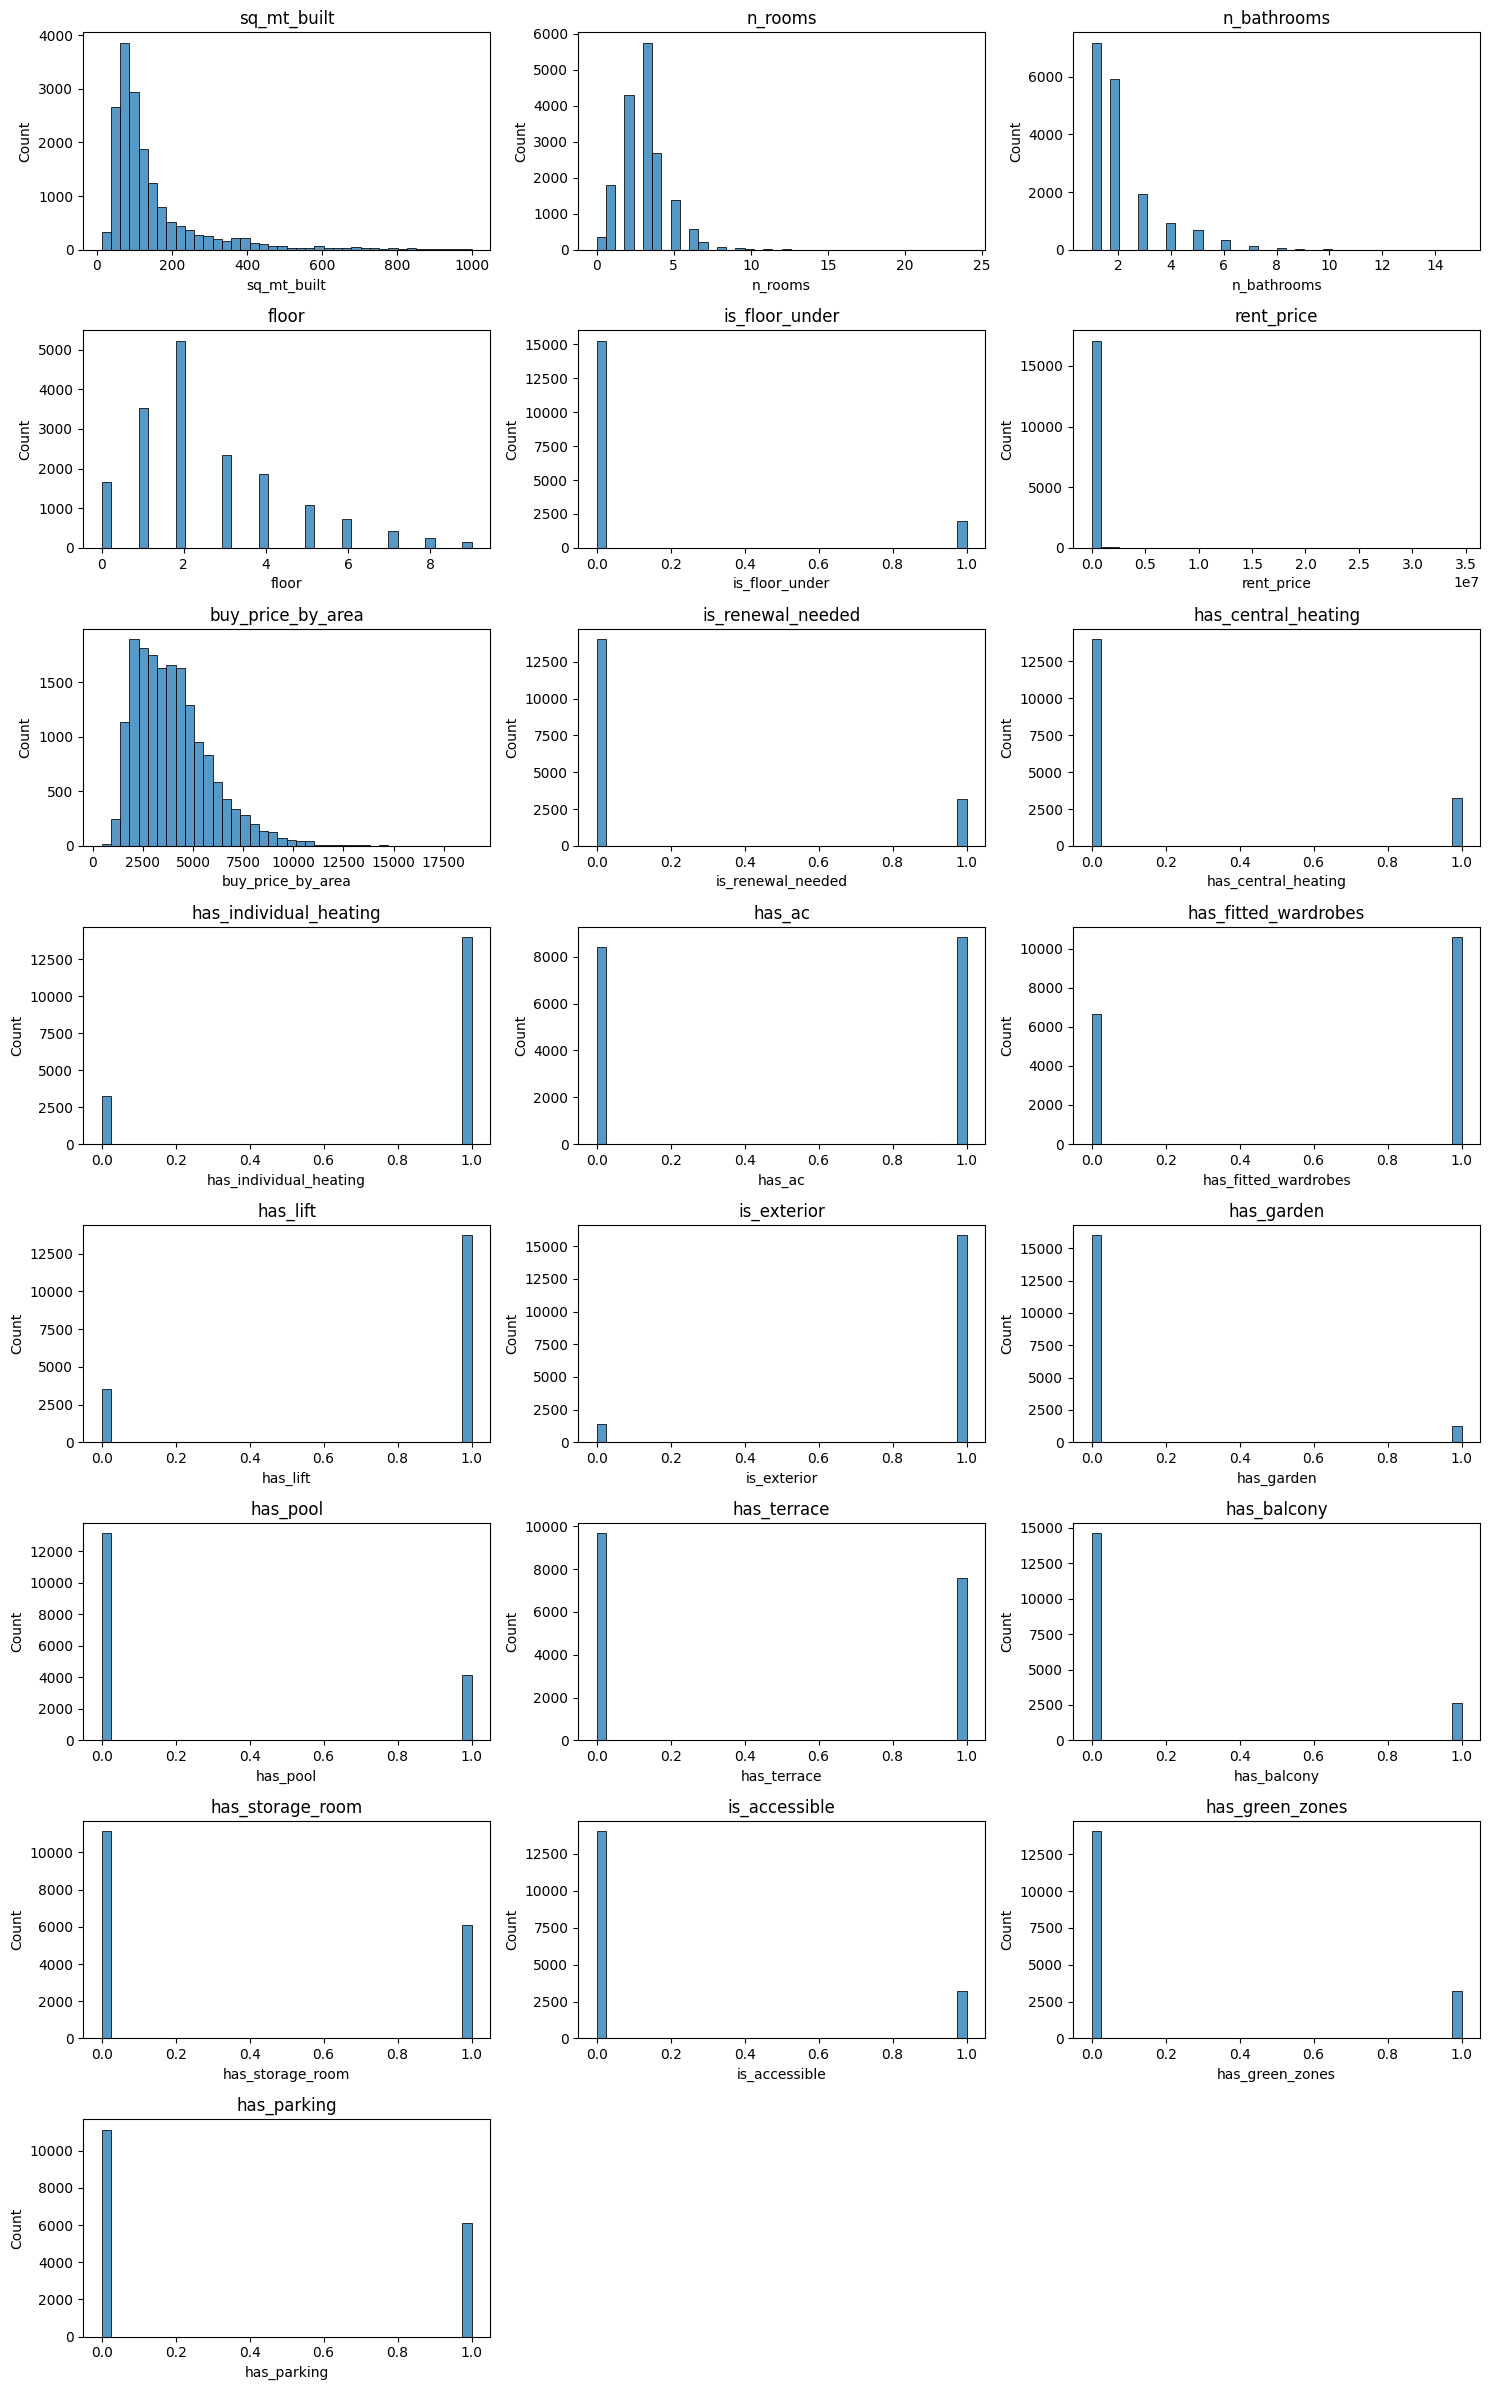

In [50]:
plot_numeric_histograms(X_train, bins=40, n_cols=3)

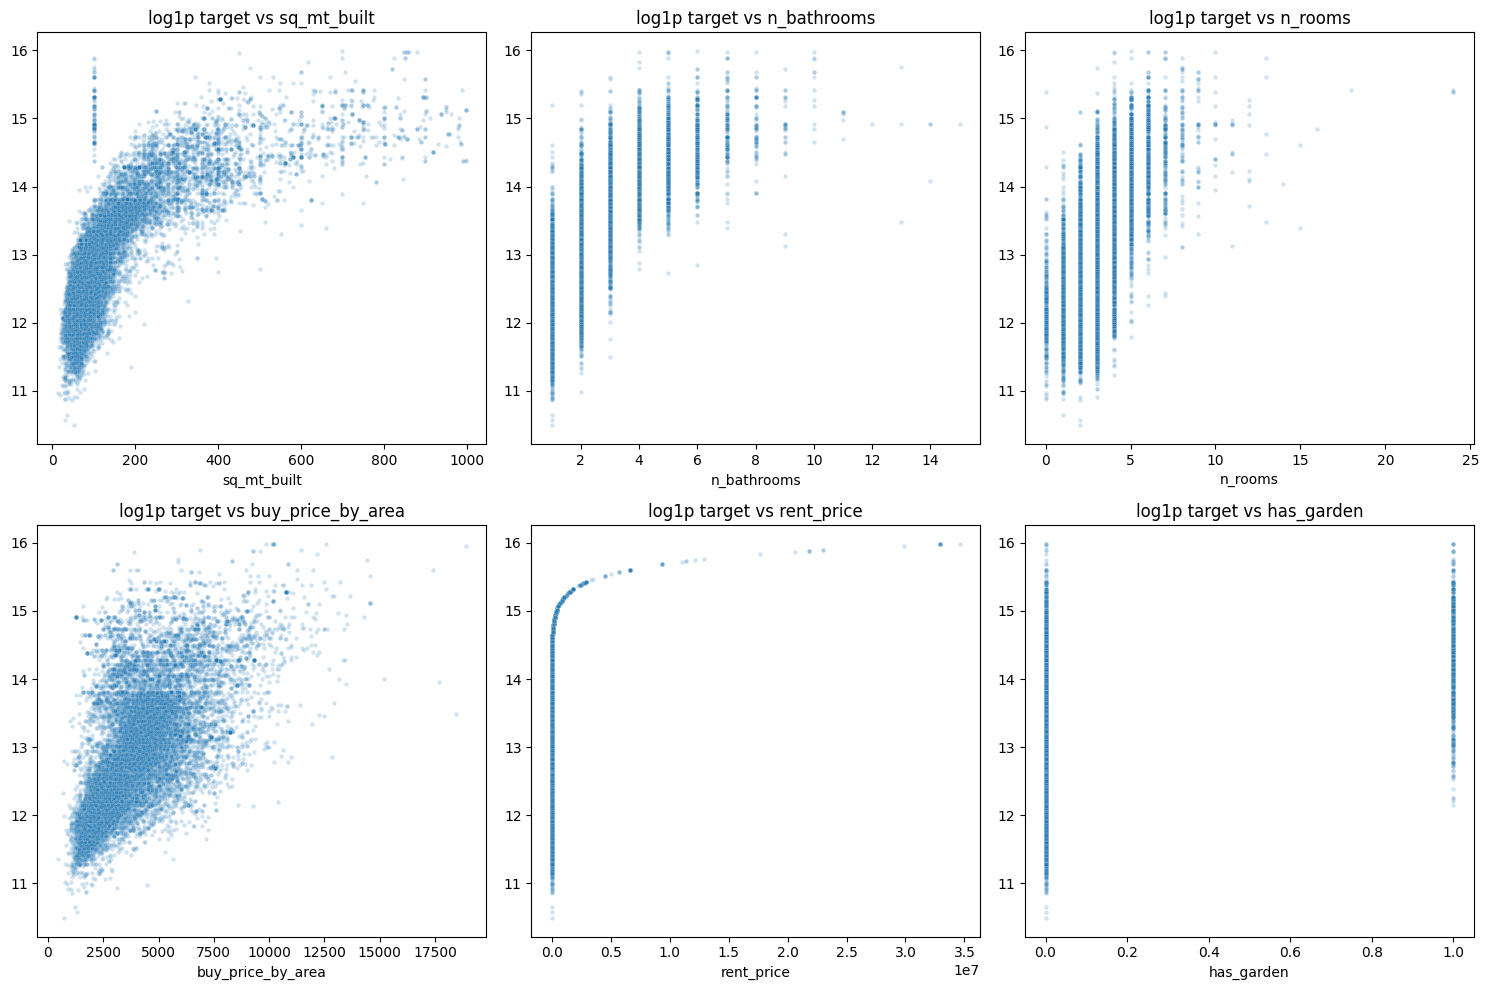

In [51]:
# Scatter top 6 vs target (log1p)
plot_scatter_vs_target(X_train, y_train, cols=top_cols[:6], transform_y="log1p")


### Analyse des scatterplots
- Les relations les plus nettes apparaissent pour les variables de surface et de salles de bain, avec une tendance globale croissante.

- **log1p target vs sq_mq_built**<br>
le nuage de point semble suivre une courbe plutôt qu'une droite<br>
ça suggère une relation non linéaire entre surface et prix.<br>
Typiquement : rendements décroissants (chaque m² supplémentaire “rapporte” moins), ou effets de seuil.<br>
C’est un argument pour tester :
    - une transformation (ex. log sur la surface)
    - des termes polynomiaux
    - un modèle non linéaire (arbres/GBM).


- La dispersion reste importante, ce qui suggère un effet de variables latentes (quartier, état du bien, équipements).
- Quelques points extrêmes persistent malgré la transformation $\log(1+y)$, indiquant des outliers résiduels.
- Si besoin, tester une transformation supplémentaire ou un modèle non linéaire pour mieux capturer la variance.


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>Justification de la sélection des variables</h3>
</div>

- **Pertinence statistique** : les variables conservées figurent parmi les plus corrélées à la target (EDA + top corrélations).
- **Interprétabilité métier** : surface, pièces, SDB et équipements ont un effet logique et attendu sur le prix.
- **Couverture des dimensions clés** : 
  - structure (surface, pièces),
  - localisation (quartier),
  - équipements (ascenseur, parking, etc.).
- **Robustesse** : on privilégie les variables disponibles et bien remplies pour limiter l’impact de l’imputation.
- **Multicolinéarité** : certaines variables redondantes (ex. `floor` vs `is_floor_under`) pourront être retirées selon les résultats.
- **Simplicité** : un set de features raisonnable facilite l’entraînement et l’explicabilité du modèle.


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h2>7) Sélection des features + export</h2>
  On conserve un set de variables cohérent pour la régression<br>

  Objectif :
  <ul>
  <li>target : `log_buy_price`</li>
  <li>features : surfaces, pièces, prix/m², quartier, équipements</li>
  <li>export d’un .feather “prêt pour modèle”</li>
  </ul>
</div>

In [52]:
features = [
    "product",
    "sq_mt_built", "n_rooms", "n_bathrooms",
    "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room",
    "is_floor_under",
    "floor",
]

# garder uniquement celles qui existent
features = select_existing_features(features, X_train.columns)

X_train_model = X_train[features].copy()

<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h2>8) Heatmap de corrélation</h2>
Objectif :
<ul>
  <li>visualiser les corrélations entre les variables numériques retenues</li>
  <li>visualiser les corrélations entre les variables numériques retenues (et la target `log_buy_price`)</li>
</ul>
<p>
Une corrélation proche de +1 : variables évoluent ensemble<br>
Proche de -1 : relation inverse</br>
Proche de 0 : peu de relation linéaire
</p>

<p style="margin-bottom: 0;">⚠️ <b>Rappel :</b> Corrélation n'est pas causalité. La corrélation de Pearson ne détecte que les relations <b>linéaires</b>.</p>

</div>


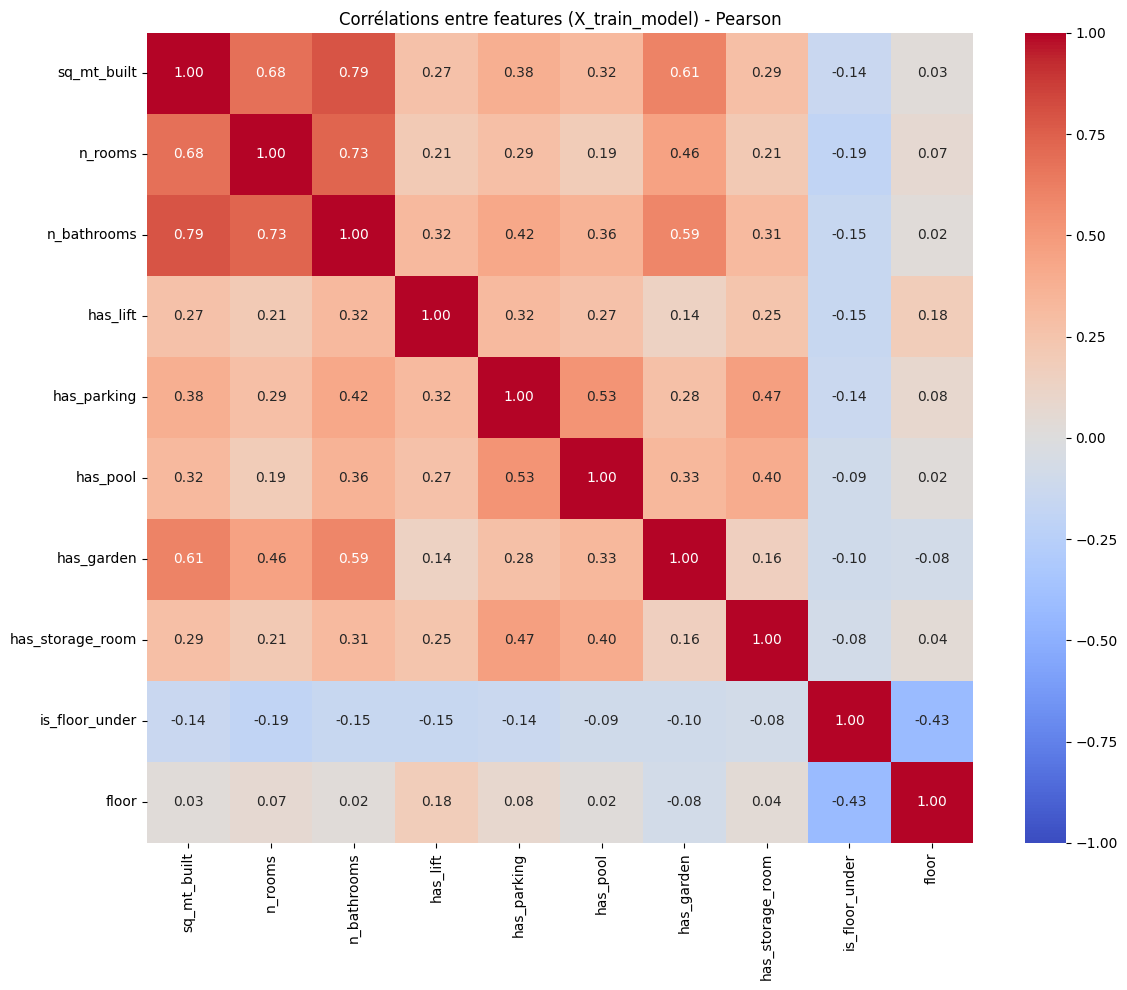

In [60]:
plot_corr_heatmap(
    X_train_model,
    title="Corrélations entre features (X_train_model) - Pearson",
)

À ce stade de l'analyse, garde tout

Le seuil critique : 0,90<br>
généralement on supprime des variables quand la corrélation dépasse ou 0,90<br>

À 0,79, chaque variable apporte encore une petite nuance spécifique<br>
ex: un grand appartement avec peu de pièces vs un petit appartement optimisé

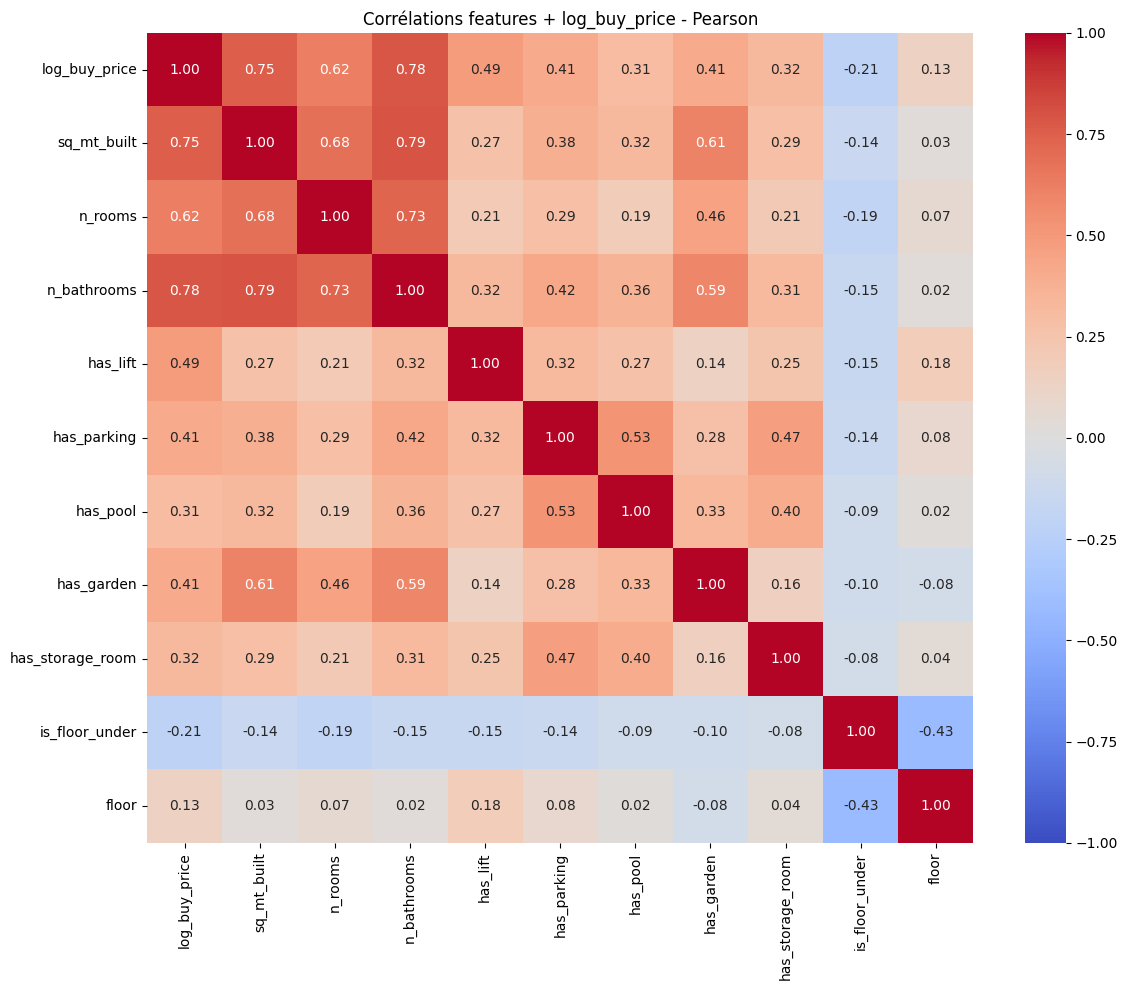

In [62]:
corr_df = X_train_model.copy()
corr_df["log_buy_price"] = np.log1p(y_train)

# Mettre la target en première colonne
corr_df = corr_df[["log_buy_price"] + [c for c in corr_df.columns if c != "log_buy_price"]]

plot_corr_heatmap(
    corr_df,
    title="Corrélations features + log_buy_price - Pearson",
    method="pearson",
)

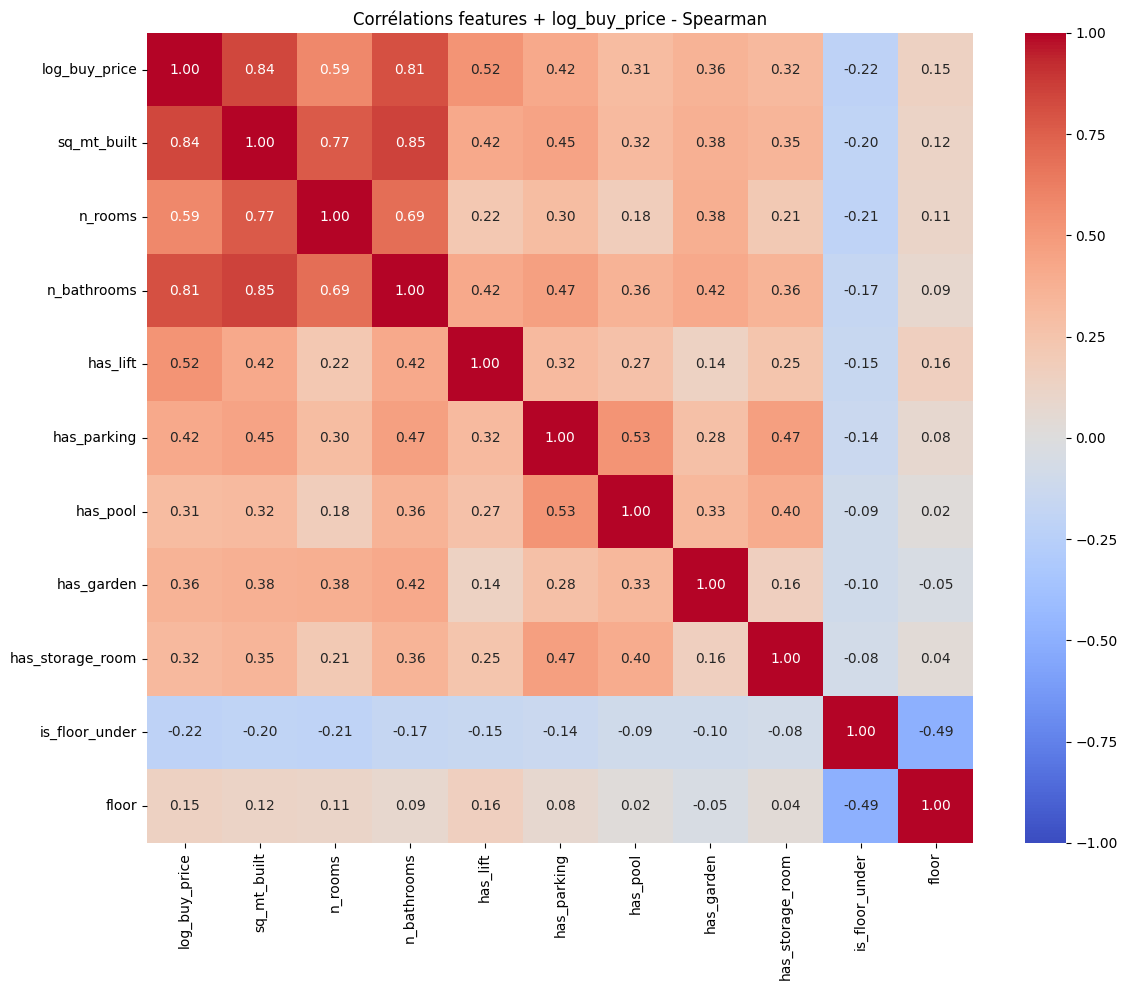

In [ ]:
corr_df = X_train_model.copy()
corr_df["log_buy_price"] = np.log1p(y_train)

# target en 1ère colonne
corr_df = corr_df[["log_buy_price"] + [c for c in corr_df.columns if c != "log_buy_price"]]

plot_corr_heatmap(
    corr_df,
    title="Corrélations features + log_buy_price - Spearman",
    method="spearman",
)

<p>La corrélation de Pearson sur la cible log_transformée rejoint les scores de Spearman<br>
Spearman est insensible à la transformation logarithmique (invariance par les rangs)</p>
<strong>
Cet alignement démontre que le passage au log a parfaitement linéarisé les relations entre les variables explicatives et le prix
</strong>

In [59]:
# On utilise les variables que tu as définies précédemment
y_log = np.log1p(y_train)

# Calcul des deux corrélations pour la variable 'sq_mt_built'
p_corr = X_train_model['sq_mt_built'].corr(y_log, method='pearson')
s_corr = X_train_model['sq_mt_built'].corr(y_train, method='spearman')

print(f"Pearson (sur Log) : {p_corr:.3f}")
print(f"Spearman (sur Brut) : {s_corr:.3f}")
print(f"Différence : {abs(p_corr - s_corr):.4f}")

Pearson (sur Log) : 0.751
Spearman (sur Brut) : 0.841
Différence : 0.0899


In [ ]:
dup_count = X_train.duplicated().sum()
print("Doublons (lignes identiques):", dup_count)

Doublons (lignes identiques): 55


In [82]:
X_train_model = X_train_model.drop(columns=["floor"])

<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h2>10) Export du dataset final</h2>
Exporte le dataset de features prêt à être utilisé par les modèles de régression



**Note target**
- Les fichiers `y_train/y_test` exportés sont en brut (pas loggés).
- La transformation log est appliquée dans 3_model.ipynb.

In [83]:
# IMPORTANT: Appliquer le cleaning AVANT d'exporter !
print(f"Après cleaning: X_train {X_train.shape}, X_test {X_test.shape}")

export_train_test_feather(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    output_dir="data_model",
    target_name="buy_price",
    transform_y=None,
    drop_cols=["log_buy_price"],
)

print("✅ Export terminé des 4 jeux X/y train/test dans data_model/ !")
print(f"Train set : {X_train.shape}")
print(f"Test set  : {X_test.shape}")
print(f"⚠️  Target : buy_price brute (log appliqué dans 3_model.ipynb)")

Après cleaning: X_train (17247, 25), X_test (4312, 25)
✅ Export terminé des 4 jeux X/y train/test dans data_model/ !
Train set : (17247, 25)
Test set  : (4312, 25)
⚠️  Target : buy_price brute (log appliqué dans 3_model.ipynb)
